# Equilibria

This notebook has the main purpose to investigate the reaching of the equilibria for differnet initial conditions. 
The definition of equilibrium for an evolving schelling city, is defined byGauvin et Al. " _What is meant by equilibrium here may correspond
to two different situations: (i) the system does not evolve
at all anymore (fixed point); (ii) the systems reaches some
stationary state: the fluctuations of the studied parameters
remain weak during a large number of time steps_". 
We will refer to the (ii) case and evaluate these fluctuations throught the standard deviation of these models. 

In [1]:
import random
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import matplotlib.patches as mpatches
import seaborn as sns
from mpl_toolkits.axes_grid1 import ImageGrid
from scipy.signal import convolve2d
import warnings
import pickle 
from multiprocessing import Pool, cpu_count
from class_schelling import Schelling, UnionFind, hoshen_kopelman, step
from pollo import compute_metrics, parallel_compute_metrics
from run_all import compute_metrics as cm
from run_all import parallel_compute_metrics as pcm

We initialize T x P x C models with different parameters and C = 20 different channel for the same initial parameters. 

In [6]:
T = np.arange(0.2, .9, 0.02)
P = np.arange(.02, .2, .04)

N = np.arange(36000) # number of time steps
C = np.arange(20)   # number of channels 

# Tensor containing all of our models. Here we create a tensor (T x P X C) 
# with the same model (p, t) initialized in the same way for C different channels 

# Then we initialize different tensors to keep track of the model as the model evolves

Models = np.empty(( len(T), len(P), len(C)), dtype=object)
Models_energy = np.empty((len(T), len(P), len(C), len(N) ))
Models_bc_energy = np.empty((len(T), len(P), len(C), len(N) ))
Models_satisfaction_ratio = np.empty((len(T), len(P), len(C), len(N) ))
Models_density_unwanted = np.empty((len(T), len(P), len(C), len(N) ))
Models_segregation_coefficient = np.empty((len(T), len(P), len(C), len(N) ))
#initializing the model

for i, t in enumerate(T): 
  for j, p in enumerate(P): 
    x = Schelling(30, t, p, .5)
    for k in C:
      Models[i, j, k]  = Schelling(30, t, p, .5, x.city)  # for the same parameters we give the same initial conditions


We now let  all the model evolve for N = 36000 time steps and store all the significant parameters stepwise.
Even if the simulation has been optimized throught multiprocessing, it is still a significant time consuming step. 

In [7]:
Models_energy, Models_bc_energy, Models_density_unwanted, Models_satisfaction_ratio, Models_segregation_coefficient =  parallel_compute_metrics(T, P, C, N, Models, num_processes=4)

Once gained the values, we check that an equilibrium has been reached for all of them 
How we do it it thourght comparing the standard devidation of the last N = 100 steps for all the parameters.

In [29]:
values = {"energy": [],"bc_energy": [], "satisfaction_ratio": [], "density_unwanted": [], "segregation":[]}
for i, t in enumerate(T): 
  for j, p in enumerate(P): 
    for k in C:
        values["energy"].append(np.std(Models_energy[i, j, k, 35900:]))
        values["bc_energy"].append(np.std(Models_bc_energy[i, j, k, 35900:]))
        values["satisfaction_ratio"].append(np.std(Models_satisfaction_ratio[i, j, k, 35900:]))
        values[ "density_unwanted"].append(np.std(Models_density_unwanted[i, j, k, 35900:]))
        values["segregation"].append(np.std(Models_segregation_coefficient[i, j, k, 35900:]))
          

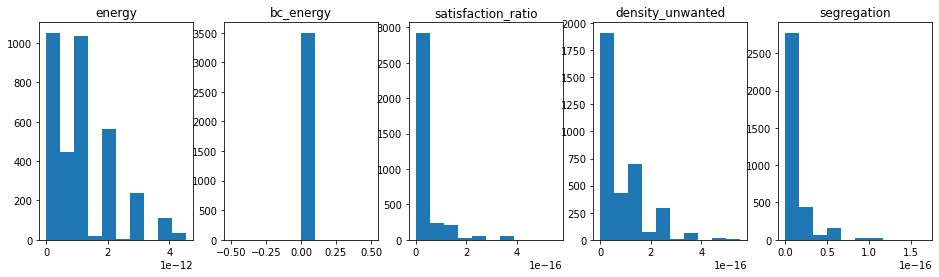

In [34]:
fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(16, 4))

for i, k in enumerate(values.keys()):
    axes[i].hist(values[k])
    axes[i].set_title(f'{k}')


We observe that all of those are significanlty close to zero, thus we can safely assume the equilibrium has been reached. 

## Storing values obtained 


In [52]:
import pickle 

In [53]:
classes_schelling = {}
for i, t in enumerate(T): 
  for j, p in enumerate(P): 
    for k in C:
        key = "t"+str(t)+"p"+str(p)+"c"+str(k)
        classes_schelling[key]= Models[i, j, k]

In [85]:
chiavi = classes_schelling.keys()

In [80]:
# Save the dictionary of objects to a file using pickle
file_path = '/Users/mariamorandini/Desktop/classi_equi.obj'
with open(file_path, 'wb') as file:
    pickle.dump(classes_schelling, file)

In [81]:
# Load the dictionary of objects from the file
with open(file_path, 'rb') as file:
    loaded_objects = pickle.load(file)

In [95]:
folder_path = "/Users/mariamorandini/Desktop/thesis/schelling/risultati/energy"
for i, t in enumerate(T): 
  for j, p in enumerate(P): 
    for k in C:
        np.save(folder_path+ f'energy_t_{t}_p_{p}_c{k}.npy', Models_energy[i, j, k])

folder_path = "/Users/mariamorandini/Desktop/thesis/schelling/risultati/bc_energy"
for i, t in enumerate(T): 
  for j, p in enumerate(P): 
    for k in C:
        np.save(folder_path + f'energy_bc_t_{t}_p_{p}_c{k}.npy',  Models_bc_energy[i, j, k])

folder_path = "/Users/mariamorandini/Desktop/thesis/schelling/risultati/satisfaction"
for i, t in enumerate(T): 
  for j, p in enumerate(P): 
    for k in C:
        np.save(folder_path + f'satisfacttion_t_{t}_p_{p}_c{k}.npy', Models_satisfaction_ratio[i, j, k])

folder_path = "/Users/mariamorandini/Desktop/thesis/schelling/risultati/density_unwanted"
for i, t in enumerate(T): 
  for j, p in enumerate(P): 
    for k in C:  
        np.save(folder_path + f'unwanted_t_{t}_p_{p}_c{k}.npy', Models_density_unwanted[i, j, k])

        
folder_path = "/Users/mariamorandini/Desktop/thesis/schelling/risultati/segregation"
for i, t in enumerate(T): 
  for j, p in enumerate(P): 
    for k in C:
        np.save(folder_path + f'segregation_t_{t}_p_{p}_c{k}.npy', Models_segregation_coefficient[i, j, k])


## evolution after equilibria 

To stay as close as possible to the setting of Gauvin et al, we must let evolve our model for 30 000 more steps after the reaching of equilibria. 
(rk : to ease the code we used a single standardized value for the number of steps)

In [3]:
# reloading datas 
file_path = '/Users/mariamorandini/Desktop/classi_equi.obj'
with open(file_path, 'rb') as file:
    loaded_objects = pickle.load(file)

In [13]:
T = np.arange(0.2, .9, 0.02)
P = np.arange(.02, .2, .04)
C = np.arange(20)   # number of channels 
N = np.arange(30000)

# Tensor containing all of our models. Here we create a tensor (T x P X C) 
# with the same model (p, t) initialized in the same way for C different channels 

# Then we initialize different tensors to keep track of the model as the model evolves

Models = np.empty(( len(T), len(P), len(C)), dtype=object)
Models_energy = np.empty((len(T), len(P), len(C)))
Models_bc_energy = np.empty((len(T), len(P), len(C) ))
Models_satisfaction_ratio = np.empty((len(T), len(P), len(C)  ))
Models_density_unwanted = np.empty((len(T), len(P), len(C)  ))
Models_segregation_coefficient = np.empty((len(T), len(P), len(C)  ))

for i, t in enumerate(T): 
  for j, p in enumerate(P): 
    x = Schelling(30, t, p, .5)
    for k in C:
        key = "t"+str(t)+"p"+str(p)+"c"+str(k)
        Models[i, j, k]  = loaded_objects[key] # for the same parameters we give the same initial conditions

        

In [14]:
Models_energy, Models_bc_energy, Models_density_unwanted, Models_satisfaction_ratio, Models_segregation_coefficient =  pcm(T, P, C, N, Models, num_processes=4)

In [15]:
# saving the results obtained 

In [16]:
classes_schelling = {}
for i, t in enumerate(T): 
  for j, p in enumerate(P): 
    for k in C:
        key = "t"+str(t)+"p"+str(p)+"c"+str(k)
        classes_schelling[key]= Models[i, j, k]

In [17]:
# Save the dictionary of objects to a file using pickle
file_path = '/Users/mariamorandini/Desktop/classi_equilibri_finali.obj'
with open(file_path, 'wb') as file:
    pickle.dump(classes_schelling, file)

In [18]:
folder_path = "/Users/mariamorandini/Desktop/thesis/schelling/risultati_post_eq"
for i, t in enumerate(T): 
  for j, p in enumerate(P): 
    for k in C:
        np.save(folder_path+ f'energy_t_{t}_p_{p}_c{k}.npy', Models_energy[i, j, k])

for i, t in enumerate(T): 
  for j, p in enumerate(P): 
    for k in C:
        np.save(folder_path + f'energy_bc_t_{t}_p_{p}_c{k}.npy',  Models_bc_energy[i, j, k])

for i, t in enumerate(T): 
  for j, p in enumerate(P): 
    for k in C:
        np.save(folder_path + f'satisfacttion_t_{t}_p_{p}_c{k}.npy', Models_satisfaction_ratio[i, j, k])


for i, t in enumerate(T): 
  for j, p in enumerate(P): 
    for k in C:  
        np.save(folder_path + f'unwanted_t_{t}_p_{p}_c{k}.npy', Models_density_unwanted[i, j, k])

for i, t in enumerate(T): 
  for j, p in enumerate(P): 
    for k in C:
        np.save(folder_path + f'segregation_t_{t}_p_{p}_c{k}.npy', Models_segregation_coefficient[i, j, k])
